# NVIDIA TensorRT MNIST Example with Triton Inference Server

![digit](digit.png)

This example shows how you can deploy a TensorRT model with NVIDIA Triton Server. In this case we use a prebuilt TensorRT model for NVIDIA v100 GPUs.

Note this example requires some advanced setup and is directed for those with tensorRT experience.

## Prerequisites

  * Install requirements in `requirements.txt`
  * An authorized kubernetes cluster with V100 GPUs installed and configured. 
     * For GKE see [GKE GPU Documentation](https://cloud.google.com/kubernetes-engine/docs/how-to/gpus)
  * [Install Seldon Core](file:///home/clive/work/seldon-core/fork-seldon-core/doc/_build/html/examples/seldon_core_setup.html) and install Ambassador and port-foward to Ambassador on localhost:8003
  
  
This example uses the [KFServing protocol supported by Triton Infernence Server](https://github.com/triton-inference-server/server/tree/master/docs/protocol) which Seldon also supports.

In [1]:
%matplotlib inline
import json
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)



In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) * 255, label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

npX = tfds.as_numpy(
    ds_train, graph=None
)

In [4]:
MEANS=np.array([255.0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,254,254,253,252,252,251,251,252,252,253,254,254,255,255,255,255,255,255,255,255,255,255,255,255,255,254,254,253,251,249,248,245,243,242,242,243,246,248,251,253,254,255,255,255,255,255,255,255,255,255,255,255,254,253,250,247,242,235,228,220,213,210,211,216,224,232,240,246,251,253,254,255,255,255,255,255,255,255,255,254,251,248,242,234,223,211,196,181,170,164,166,175,189,205,221,233,243,248,252,254,255,255,255,255,255,255,254,252,248,241,231,217,202,184,166,149,136,131,134,143,159,180,201,220,234,243,249,253,255,255,255,255,255,254,253,249,243,233,219,201,181,161,143,130,122,120,122,129,141,161,185,208,227,240,248,252,254,255,255,255,255,254,251,246,238,226,208,187,164,146,135,131,132,133,132,133,139,154,178,202,223,239,248,252,255,255,255,255,254,253,251,245,236,221,200,177,156,144,144,150,156,156,151,144,144,156,178,202,224,240,249,253,255,255,255,255,254,253,251,245,235,218,195,172,155,152,161,172,176,170,161,150,149,161,183,207,227,242,250,254,255,255,255,255,255,254,251,246,234,215,191,168,156,160,173,182,179,169,157,147,149,166,190,213,230,243,251,254,255,255,255,255,255,254,252,246,233,212,186,165,157,164,175,176,165,153,142,137,147,170,196,217,231,242,251,255,255,255,255,255,255,254,252,245,230,207,182,163,158,164,168,158,143,131,125,128,146,174,200,218,231,241,250,254,255,255,255,255,255,255,252,243,227,205,181,164,159,161,157,139,124,115,118,127,148,176,199,216,230,240,249,254,255,255,255,255,255,254,251,241,224,204,184,169,163,160,150,132,119,116,123,133,153,177,197,214,228,240,249,254,255,255,255,255,255,254,251,239,222,205,189,177,171,166,154,139,129,128,134,144,159,177,195,213,228,241,249,254,255,255,255,255,255,254,249,237,222,207,195,186,180,175,166,153,143,140,142,150,162,178,195,214,230,242,250,254,255,255,255,255,255,253,247,235,220,207,197,189,183,179,172,160,148,142,143,150,161,178,198,217,233,244,250,254,255,255,255,255,255,253,246,233,218,204,192,184,177,172,165,153,142,137,139,148,163,183,204,222,236,246,251,254,255,255,255,255,255,253,247,234,218,201,186,174,165,157,148,137,130,129,137,151,171,194,214,230,242,248,252,254,255,255,255,255,255,253,249,238,222,203,184,168,154,143,132,124,123,130,145,165,188,209,227,239,247,251,253,255,255,255,255,255,255,254,251,244,232,214,194,174,156,142,132,130,134,148,167,189,210,226,238,246,250,253,254,255,255,255,255,255,255,255,253,250,243,231,215,196,178,163,155,156,164,179,197,215,230,240,247,251,253,254,255,255,255,255,255,255,255,255,254,253,251,246,238,228,217,208,203,204,210,218,228,236,243,248,251,253,254,255,255,255,255,255,255,255,255,255,255,255,254,252,249,245,241,238,237,237,239,242,245,247,250,252,253,254,255,255,255,255,255,255,255,255,255,255,255,255,254,254,253,252,250,249,248,249,249,250,252,253,253,254,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,254,254,254,255,255,255,255,255,255,255,255,255,255,255,255])

In [5]:
%%writefile model.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: mnist
spec:
  protocol: kfserving
  transport: rest
  predictors:
  - graph:
      children: []
      implementation: TRITON_SERVER
      modelUri: gs://seldon-models/tensorrt/v100_mnist
      name: mnist
    componentSpecs:
    - spec:
        containers:
        - name: mnist
          resources:
            limits:
              nvidia.com/gpu: 1
    name: tensorrt
    replicas: 1

Overwriting model.yaml


In [6]:
!kubectl apply -f model.yaml

seldondeployment.machinelearning.seldon.io/mnist created


In [7]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=mnist -o jsonpath='{.items[0].metadata.name}')

deployment "mnist-tensorrt-0-mnist" successfully rolled out


Check metadata of model

In [8]:
!curl http://0.0.0.0:8003/seldon/default/mnist/v2/models/mnist

{"name":"mnist","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"data","datatype":"FP32","shape":[-1,1,28,28]}],"outputs":[{"name":"prob","datatype":"FP32","shape":[-1,10,1,1]}]}

Test prediction on random digit.

{'model_name': 'mnist', 'model_version': '1', 'outputs': [{'name': 'prob', 'datatype': 'FP32', 'shape': [1, 10, 1, 1], 'data': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}]}
Truth 4 predicted 4


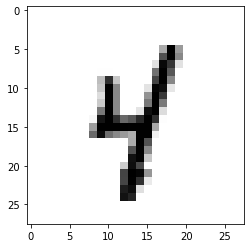

In [9]:
x,y = next(npX)
X = 255 - x
X = (X.reshape(784) - MEANS) 
gen_image(x)
values = np.expand_dims(X, axis=0).reshape((1,1,28,28)).flatten().tolist() 
cmd = '{"inputs":[{"name":"data","data":'+str(values)+',"datatype":"FP32","shape":[1,1,28,28]}]}'
with open("input.json","w") as f:
    f.write(cmd)
res=!curl -s -d @./input.json \
        -X POST http://0.0.0.0:8003/seldon/default/mnist/v2/models/mnist/infer \
        -H "Content-Type: application/json"
d=json.loads(res[0])
print(d)
predicted = np.array(d["outputs"][0]["data"]).argmax()
print("Truth",y,"predicted",predicted)